## Apple stock price prediction using LSTM

#### Got dataset from kaggle https://www.kaggle.com/datasets/iamtanmayshukla/apple-inc-aapl-stock-data-1980-2024
#### I did the coding with Google Colab

In [57]:
# Mount my google drive (connect to my google drive account)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense


#### Apple dataset contains stock history (1984 - 2025)

#### Load the data and inspect them (Use 3171 length of dataset - Drom 2012-06-11 to 2025-01-17)



In [59]:
# Apple Dataset path
apple_dataset_p = '/content/drive/MyDrive/DeepLearning/Stock-price-LSTM/Dataset/aapl_us_2025.csv'

# Get the dataset from the path and cut the first 7000 data because the data has a long history.
apple_2025 = pd.read_csv(apple_dataset_p)[7000:]
print(f"Dataset length:{len(apple_2025)}")
print(f"Train dataset length: 2400")
print(f"Test dataset length:{len(apple_2025)-2400}")
print('-'*70)
print(f"Dataset head: \n{apple_2025.head(3)}")
print('-'*70)
print(f"Dataset tail: \n{apple_2025.tail(3)}")
print('-'*70)
print(apple_2025.info())

Dataset length:3171
Train dataset length: 2400
Test dataset length:771
----------------------------------------------------------------------
Dataset head: 
            Date     Open     High      Low    Close        Volume
7000  2012-06-11  17.7256  17.7495  17.2090  17.2270  6.997771e+08
7001  2012-06-12  17.3257  17.3910  17.0916  17.3771  5.156128e+08
7002  2012-06-13  17.3277  17.4452  17.2032  17.2566  3.477900e+08
----------------------------------------------------------------------
Dataset tail: 
             Date     Open    High     Low   Close      Volume
10168  2025-01-15  234.635  238.96  234.43  237.87  39831969.0
10169  2025-01-16  237.350  238.01  228.03  228.26  71759052.0
10170  2025-01-17  232.115  232.29  228.48  229.98  68488301.0
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3171 entries, 7000 to 10170
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  ------

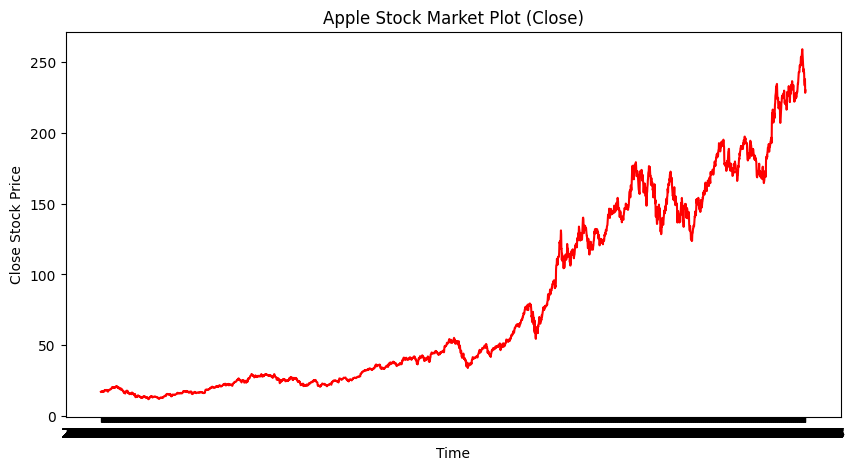

In [60]:
# First let's see on plot how our data looks like.
plt.figure(figsize=(10, 5))
plt.plot(apple_2025['Date'], apple_2025['Close'], color='red')
plt.title('Apple Stock Market Plot (Close)')
plt.xlabel('Time')
plt.ylabel('Close Stock Price')
plt.show()

#### Split the data into training and test sets. I will predict more than two weeks. It will be 771 day prediction.

In [61]:
# Simply use iloc to seperate train and test dataset
# We cut 7000 rows, so we have 3171 data and use 2400 for training and others will be used for testing
# use close stock values only
training_apple = apple_2025.iloc[:2400, 4:5].values
test_apple = apple_2025.iloc[2400:, 4:5].values

In [62]:
# This is how we rescale our data.
# Change our data scale in between 0 and 1.
mms = MinMaxScaler(feature_range=(0, 1))
t_apple = mms.fit_transform(training_apple)
te_apple = mms.transform(test_apple)
len(t_apple)

2400

In [63]:
training_x1 = []
training_y1 = []
training_x7 = []
training_y7 = []
training_x14 = []
training_y14 = []
for i in range(7, 2400):
    training_x7.append(t_apple[i-7:i, 0])
    training_y7.append(t_apple[i, 0])

# change to numpy array
training_x7 = np.array(training_x7)
training_y7 = np.array(training_y7)

shape3 = training_x7.shape[0]
shape4 = training_x7.shape[1]
training_x7, training_y7 = np.array(training_x7), np.array(training_y7)
training_x7 = training_x7.reshape((shape3, shape4, 1))
training_x7.shape[0]

2393

#### Set time lags (1 day, 7 days, 14 days). To make easy to understand, I will not use the loop in this case.

In [64]:
# For training dataset
training_x1 = []
training_y1 = []
training_x7 = []
training_y7 = []
training_x14 = []
training_y14 = []

for i in range(1, 2400):
    training_x1.append(t_apple[i-1:i, 0])
    training_y1.append(t_apple[i, 0])

# change to numpy array
training_x1 = np.array(training_x1)
training_y1 = np.array(training_y1)

training_x1, training_y1 = np.array(training_x1), np.array(training_y1)
training_x1 = training_x1.reshape((2399, 1, 1))

for i in range(7, 2400):
    training_x7.append(t_apple[i-7:i, 0])
    training_y7.append(t_apple[i, 0])

# change to numpy array
training_x7 = np.array(training_x7)
training_y7 = np.array(training_y7)

training_x7, training_y7 = np.array(training_x7), np.array(training_y7)
training_x7 = training_x7.reshape((2393, 7, 1))

for i in range(14, 2400):
    training_x14.append(t_apple[i-14:i, 0])
    training_y14.append(t_apple[i, 0])

# change to numpy array
training_x14 = np.array(training_x14)
training_y14 = np.array(training_y14)

training_x14, training_y14 = np.array(training_x14), np.array(training_y14)
training_x14 = training_x14.reshape((2386, 14, 1))

In [65]:
# For test dataset
# Combine the last 60 training values with the test set
comb_data1 = np.concatenate((training_apple[-1:], test_apple), axis=0)
comb_data7 = np.concatenate((training_apple[-7:], test_apple), axis=0)
comb_data14 = np.concatenate((training_apple[-14:], test_apple), axis=0)


# Build sequences
testing_x1 = []
testing_x7 = []
testing_x14 = []

# 1 day
for i in range(1, len(te_apple)):
    testing_x1.append(te_apple[i-1:i, 0])
testing_x1 = np.array(testing_x1)

testing_x1 = np.array(testing_x1)
testing_x1 = testing_x1.reshape((770, 1, 1))

# 7 days
for i in range(7, len(te_apple)):
    testing_x7.append(te_apple[i-7:i, 0])
testing_x7 = np.array(testing_x7)

testing_x7 = np.array(testing_x7)
testing_x7 = testing_x7.reshape((764, 7, 1))

# 14 days
for i in range(14, len(te_apple)):
    testing_x14.append(te_apple[i-14:i, 0])
testing_x14 = np.array(testing_x14)

testing_x14 = np.array(testing_x14)
testing_x14 = testing_x14.reshape((757, 14, 1))

#### Build LSTM mode, decide how many neurons and how many layers, and design loss function and optimizer.

#### 1 day model with 4 LSTM layers, 40% dropout, batch size 50, and 100 neurons. 1-1 day model will have 6 LSTM layers 40% dropout, batch size 100 with 100 neurons. 1-2 day model will have 6 LSTM layers 50% dropout, batch size 32 with 50 neurons. 1-3 day model will have 4 LSTM layers, 40% dropouts, and 100 neurons, but 100 batch size. I will compare them.  

In [79]:
# LSTM model
shape_x = training_x1.shape[1]
model1 = Sequential()

model1.add(LSTM(units=100, return_sequences=True, input_shape=(shape_x, 1)))
model1.add(Dropout(0.4))

model1.add(LSTM(units=100, return_sequences=True))
model1.add(Dropout(0.4))

model1.add(LSTM(units=100, return_sequences=True))
model1.add(Dropout(0.4))

model1.add(LSTM(units=100))
model1.add(Dropout(0.4))

model1.add(Dense(units=1))

# Compile the model
# Use Adam optimizer and use MSE to obtain better model
model1.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model1.fit(training_x1, training_y1, epochs=100, batch_size=50)

# save my model1 to google drive
model1.save('apple_lstm_model1.h5')

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0755
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0152
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017
Epoch 13/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017
Epoch 14/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015
Epoch 15/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014
Epoch 16/100
48/

#### 1-1 day model (6 LSTM layers 40% dropout with 100 neurons, and batch size 100)

In [80]:
# LSTM model
shape_x = training_x1.shape[1]
model1_1 = Sequential()

model1_1.add(LSTM(units=100, return_sequences=True, input_shape=(shape_x, 1)))
model1_1.add(Dropout(0.4))

model1_1.add(LSTM(units=100, return_sequences=True))
model1_1.add(Dropout(0.4))

model1_1.add(LSTM(units=100, return_sequences=True))
model1_1.add(Dropout(0.4))

model1_1.add(LSTM(units=100, return_sequences=True))
model1_1.add(Dropout(0.4))

model1_1.add(LSTM(units=100, return_sequences=True))
model1_1.add(Dropout(0.4))

model1_1.add(LSTM(units=100))
model1_1.add(Dropout(0.4))

model1_1.add(Dense(units=1))

# Compile the model
# Use Adam optimizer and use MSE to obtain better model
model1_1.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model1_1.fit(training_x1, training_y1, epochs=100, batch_size=100)

# save my model1 to google drive
model1_1.save('apple_lstm_model1_1.h5')

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0858
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0548
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0456
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0089
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0043
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021
Epoch 13/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023
Epoch 14/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023
Epoch 15/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

#### 1_2 day model (6 LSTM layers 50% dropout with 50 neurons, and batfch size 100)

In [81]:
# 1_2 LSTM model
shape_x = training_x1.shape[1]
model1_2 = Sequential()

model1_2.add(LSTM(units=50, return_sequences=True, input_shape=(shape_x, 1)))
model1_2.add(Dropout(0.5))

model1_2.add(LSTM(units=50, return_sequences=True))
model1_2.add(Dropout(0.5))

model1_2.add(LSTM(units=50, return_sequences=True))
model1_2.add(Dropout(0.5))

model1_2.add(LSTM(units=50, return_sequences=True))
model1_2.add(Dropout(0.5))

model1_2.add(LSTM(units=50, return_sequences=True))
model1_2.add(Dropout(0.5))

model1_2.add(LSTM(units=50))
model1_2.add(Dropout(0.5))

model1_2.add(Dense(units=1))

# Compile the model
# Use Adam optimizer and use MSE to obtain better model
model1_2.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model1_2.fit(training_x1, training_y1, epochs=100, batch_size=100)

# save my model1 to google drive
model1_2.save('apple_lstm_model1_2.h5')

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0889
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0588
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0552
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0521
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0236
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0112
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0088
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0080
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0059
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0051
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0064
Epoch 13/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0056
Epoch 14/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0052
Epoch 15/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - lo

#### 1_3 day model (4 LSTM layers, 40% dropouts, and 100 neurons, but 100 batch size)

In [69]:
# 1_3 LSTM model
shape_x = training_x1.shape[1]
model1_3 = Sequential()

model1_3.add(LSTM(units=100, return_sequences=True, input_shape=(shape_x, 1)))
model1_3.add(Dropout(0.4))

model1_3.add(LSTM(units=100, return_sequences=True))
model1_3.add(Dropout(0.4))

model1_3.add(LSTM(units=100, return_sequences=True))
model1_3.add(Dropout(0.4))

model1_3.add(LSTM(units=100))
model1_3.add(Dropout(0.4))

model1_3.add(Dense(units=1))

# Compile the model
# Use Adam optimizer and use MSE to obtain better model
model1_3.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model1_3.fit(training_x1, training_y1, epochs=100, batch_size=100)

# save my model1 to google drive
model1_3.save('apple_lstm_model1_3.h5')

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0856
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0473
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0145
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019
Epoch 13/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019
Epoch 14/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019
Epoch 15/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016
Ep

#### 7 day model, 4 hidden layers, 100 neurons, 40% dropout, and batch size 50.

In [82]:
# Repeat for 7 day model
# I used the same structure,
shape_x = training_x7.shape[1]
model7 = Sequential()

model7.add(LSTM(units=100, return_sequences=True, input_shape=(shape_x, 1)))
model7.add(Dropout(0.4))

model7.add(LSTM(units=100, return_sequences=True))
model7.add(Dropout(0.4))

model7.add(LSTM(units=100, return_sequences=True))
model7.add(Dropout(0.4))

model7.add(LSTM(units=100))
model7.add(Dropout(0.4))

model7.add(Dense(units=1))

# Compile the model7
model7.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model7.fit(training_x7, training_y7, epochs=100, batch_size=50)

# and save my model7 to google drive
model7.save('apple_lstm_model7.h5')

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0407
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 13/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 14/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011
Epoch 15/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011
Epoc

#### 14 day model, 4 hidden layers, 100 neurons, 40% dropout, and batch size 50.

In [83]:
# Last model 14 day lag
shape_x = training_x14.shape[1]
model14 = Sequential()

model14.add(LSTM(units=100, return_sequences=True, input_shape=(shape_x, 1)))
model14.add(Dropout(0.4))

model14.add(LSTM(units=100, return_sequences=True))
model14.add(Dropout(0.4))

model14.add(LSTM(units=100, return_sequences=True))
model14.add(Dropout(0.4))

model14.add(LSTM(units=100))
model14.add(Dropout(0.4))

model14.add(Dense(units=1))

# Compile the model14
model14.compile(optimizer='adam', loss='mean_squared_error')

model14.fit(training_x14, training_y14, epochs=100, batch_size=50)

# save my model14 to google drive
model14.save('apple_lstm_model14.h5')

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0253
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
Epoch 13/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
Epoch 14/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 15/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss:

#### Prediction

In [84]:
# Predict with test dataset for each model
pred_appstock_price1 = model1.predict(testing_x1)
pred_appstock_price1_1 = model1_1.predict(testing_x1)
pred_appstock_price1_2 = model1_2.predict(testing_x1)
pred_appstock_price1_3 = model1_3.predict(testing_x1)
pred_appstock_price7 = model7.predict(testing_x7)
pred_appstock_price14 = model14.predict(testing_x14)

# We scale back to get the original scale.
# Used (0,1) to make LSTM works better learning and less fluctuating.
pred_appstock_price1 = mms.inverse_transform(pred_appstock_price1)
pred_appstock_price1_1 = mms.inverse_transform(pred_appstock_price1_1)
pred_appstock_price1_2 = mms.inverse_transform(pred_appstock_price1_2)
pred_appstock_price1_3 = mms.inverse_transform(pred_appstock_price1_3)
pred_appstock_price7 = mms.inverse_transform(pred_appstock_price7)
pred_appstock_price14 = mms.inverse_transform(pred_appstock_price14)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


#### Prediction for 1 day model

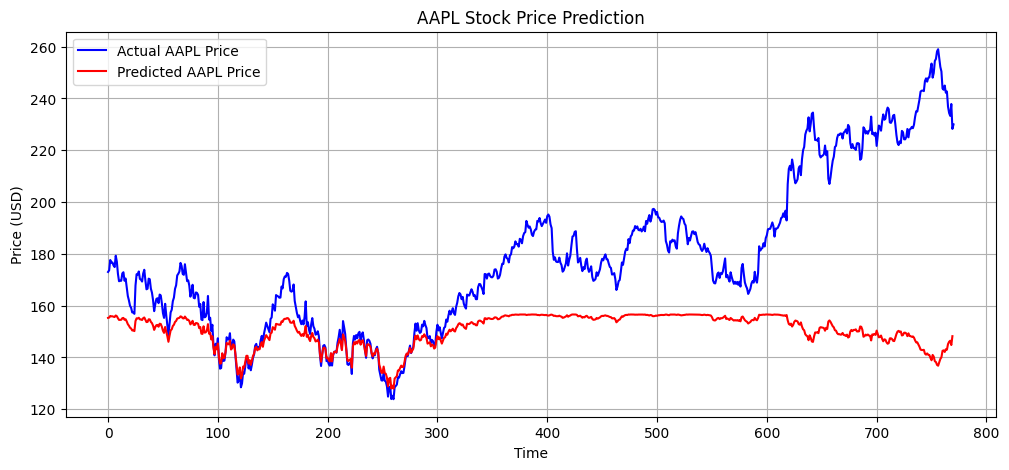

In [85]:
# Plot for the first model (1 day lag)
plt.figure(figsize=(12, 5))
plt.plot(test_apple, label='Actual AAPL Price', color='blue')
plt.plot(pred_appstock_price1, label='Predicted AAPL Price', color='red')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

#### Prediction for 1_1 day model

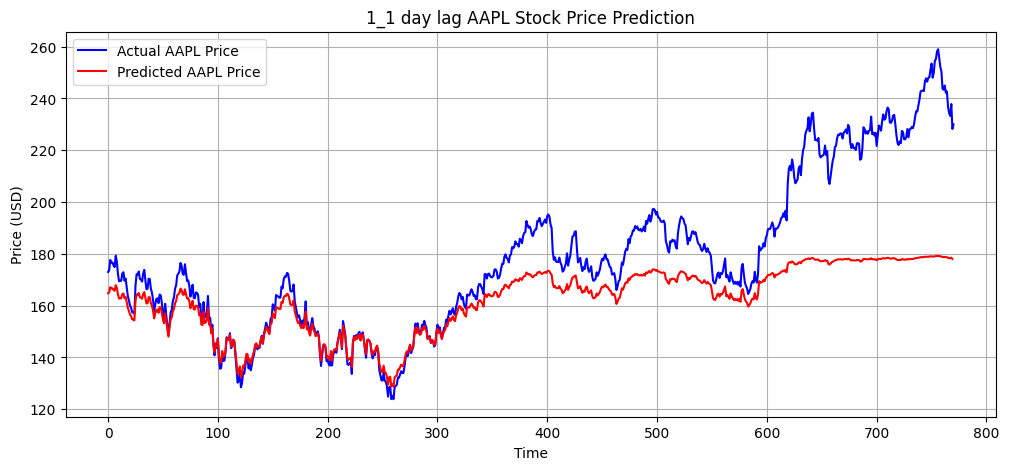

In [86]:
# Plot for the first model (1 day lag)
plt.figure(figsize=(12, 5))
plt.plot(test_apple, label='Actual AAPL Price', color='blue')
plt.plot(pred_appstock_price1_1, label='Predicted AAPL Price', color='red')
plt.title('1_1 day lag AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

#### Prediction for 1_2 day model

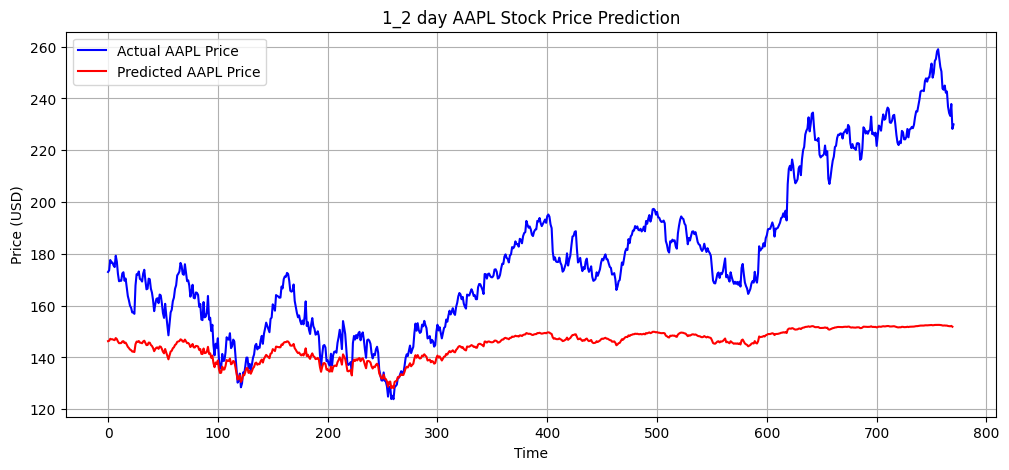

In [87]:
# Plot for the first model (1 day lag)
plt.figure(figsize=(12, 5))
plt.plot(test_apple, label='Actual AAPL Price', color='blue')
plt.plot(pred_appstock_price1_2, label='Predicted AAPL Price', color='red')
plt.title('1_2 day AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

#### Prediction for 1_3 day model

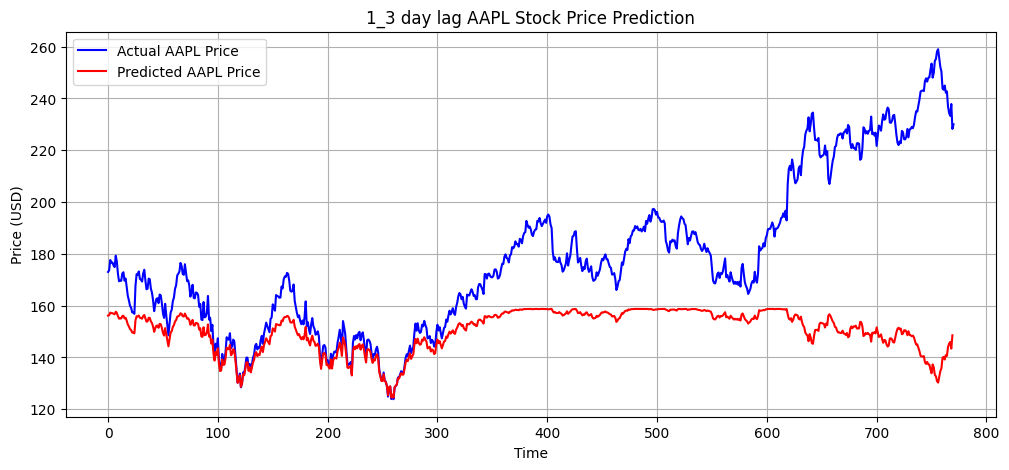

In [88]:
# Plot for the first model (1 day lag)
plt.figure(figsize=(12, 5))
plt.plot(test_apple, label='Actual AAPL Price', color='blue')
plt.plot(pred_appstock_price1_3, label='Predicted AAPL Price', color='red')
plt.title('1_3 day lag AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

#### Prediction for 7 day model

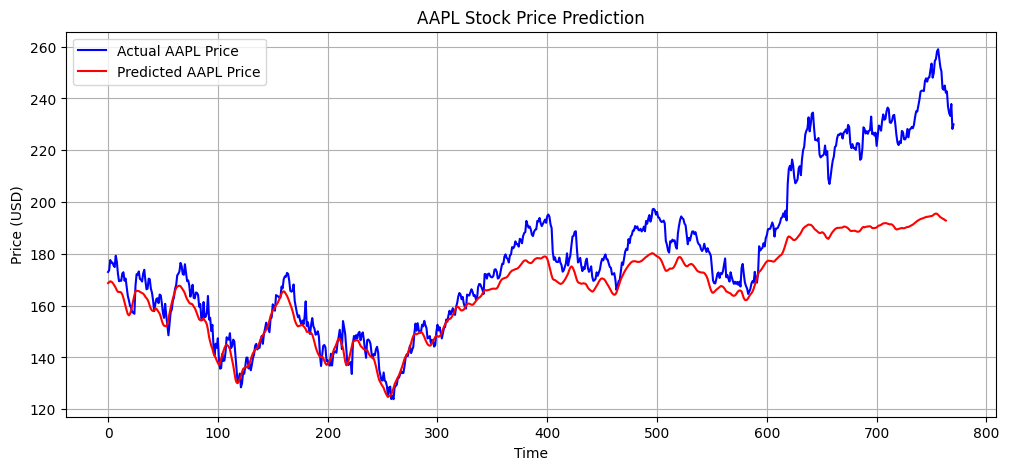

In [89]:
# Plot for the second model (7 day lag)
plt.figure(figsize=(12, 5))
plt.plot(test_apple, label='Actual AAPL Price', color='blue')
plt.plot(pred_appstock_price7, label='Predicted AAPL Price', color='red')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

#### Prediction for 14 day model

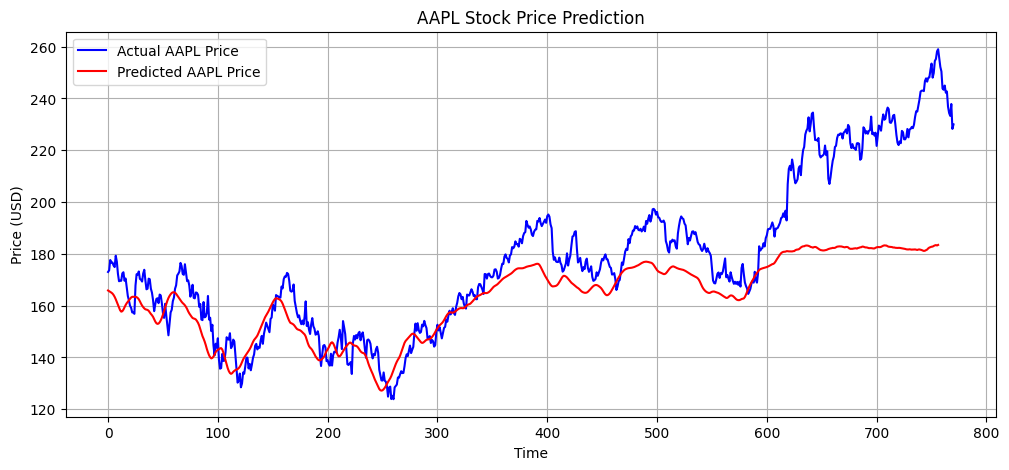

In [90]:
# Plot for the third model (14 day lag)
plt.figure(figsize=(12, 5))
plt.plot(test_apple, label='Actual AAPL Price', color='blue')
plt.plot(pred_appstock_price14, label='Predicted AAPL Price', color='red')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()